# (Problem 4) Stock Price Prediction – Minionz


## Objective  
This notebook aims to develop a machine learning model to predict stock closing prices **5 days into the future** using historical stock data.  
We will explore various models, evaluate their performance, and analyze feature importance.

## Workflow Steps:
1. **Load and Inspect Data**  
2. **Exploratory Data Analysis (EDA)**  
3. **Feature Engineering**  
4. **Preprocessing & Data Splitting**  
5. **Model Training & Selection**  
6. **Model Evaluation**  
7. **Backtesting & Simulated Trading Performance**  
8. **Conclusions & Future Improvements**

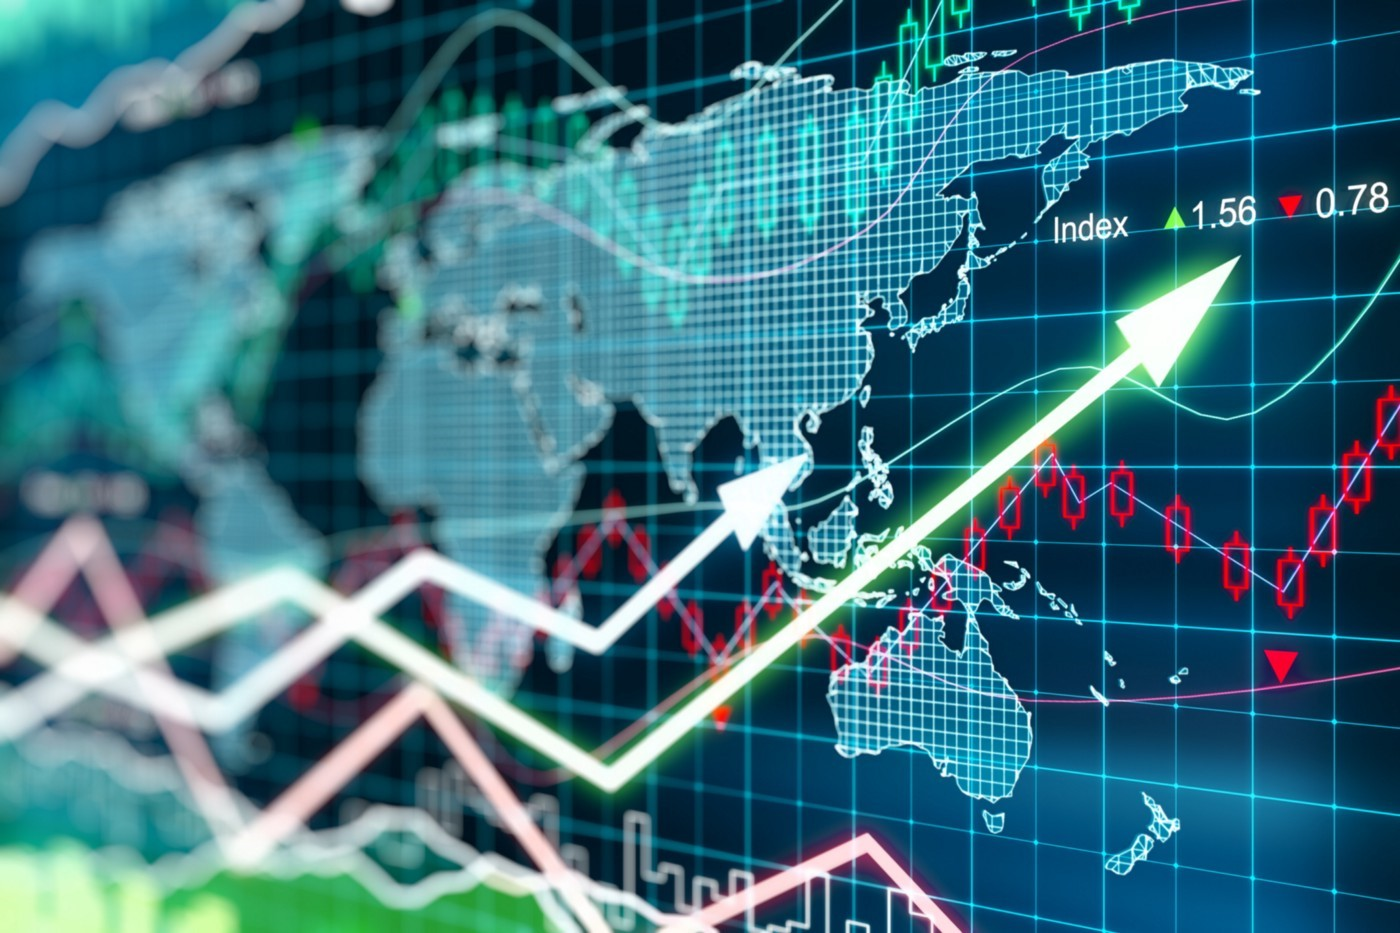

## Import Required Libraries


In [ ]:
# Data Handling
import pandas as pd
import numpy as np
import datetime as dt

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Analysis
from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import zscore

# Statistical Analysis
from statsmodels.tsa.stattools import adfuller, pacf, acf
from scipy.stats import zscore

# Model training and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Suppress warnings for better readability
import warnings
warnings.filterwarnings("ignore")

## Loading Inspecting and identifying Data

In [ ]:
# Load dataset
df = pd.read_csv("stock.csv")

In [ ]:
# Display first few rows
df.head()

,Unnamed: 0,Date,Adj Close,Close,High,Low,Open,Volume
0,0,1980-03-17,2.296798,3.291227,3.344743,3.291227,0.000000,41109.0
1,1,1980-03-18,2.306134,3.304606,3.358122,3.304606,0.000000,9343.0
2,2,1980-03-19,2.306134,3.304606,3.304606,3.304606,3.304606,0.0
3,3,1980-03-20,2.306134,3.304606,3.358122,3.304606,0.000000,10277.0
4,4,1980-03-21,2.362154,3.384880,3.438396,3.384880,0.000000,8409.0


### Check Data Information & Types

In [ ]:
# Check structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11291 entries, 0 to 11290
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  11291 non-null  int64  
 1   Date        11181 non-null  object 
 2   Adj Close   11198 non-null  float64
 3   Close       11174 non-null  float64
 4   High        11196 non-null  float64
 5   Low         11164 non-null  float64
 6   Open        11188 non-null  float64
 7   Volume      11146 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 705.8+ KB


In [ ]:
# Check for missing values
df.isnull().sum()

,0
Unnamed: 0,0
Date,110
Adj Close,93
Close,117
High,95
Low,127
Open,103
Volume,145


In [ ]:
null_date_rows = df[df['Date'].isnull()]
null_date_rows

,Unnamed: 0,Date,Adj Close,Close,High,Low,Open,Volume
103,103,NaN,2.617510,3.750795,3.792939,3.750795,0.000000,38262.0
152,152,NaN,3.195910,4.579622,4.607718,4.579622,0.000000,8898.0
196,196,NaN,2.784167,3.989610,4.003658,3.989610,0.000000,4449.0
283,283,NaN,3.921361,5.619169,5.661312,5.619169,0.000000,20466.0
286,286,NaN,3.882148,5.562977,5.605121,5.562977,0.000000,14237.0
...,...,...,...,...,...,...,...,...
10128,10128,NaN,116.889999,116.889999,117.349998,116.110001,116.199997,179100.0
10587,10587,NaN,158.270004,158.270004,161.619995,158.169998,160.740005,355800.0
10772,10772,NaN,143.190002,143.190002,144.800003,142.649994,144.759995,223400.0
11256,11256,NaN,178.449997,178.449997,179.679993,177.259995,179.000000,638000.0


### Handling missing values

Since we have rows where the date is also null, we cannot proceed further with those. (Other null values will be handled using appropriate null handling techniques.)



*   The stock market does not operate every day (e.g., weekends, holidays).
*   Missing values should be handled while considering only valid trading days.


Strategy

Missing Dates


*   Convert the Date column to datetime.
*   Identify the full range of trading dates (excluding weekends and holidays).
*   Fill missing dates and forward-fill their corresponding values.

When restructuring dates since the market related to the stock data was not provided it was not possible to consider few special holidays that can occur


In [ ]:
# Remove duplicate dates by taking the first occurrence
df = df.drop_duplicates(subset='Date', keep='first')

In [ ]:
# Ensure Date is the index
df.set_index('Date', inplace=True)

In [ ]:
# Generate a full range of trading dates (excluding weekends)
df.index = pd.to_datetime(df.index)
all_dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq='B')

In [ ]:
# Reindex the dataframe to include all trading dates
df = df.reindex(all_dates)


Filling Other Missing Values

*   Forward Fill (ffill) for price-related columns (Adj Close, Close, High, Low, Open) since stock prices don't jump arbitrarily.
*   Interpolate for Volume, as it's a fluctuating metric and forward-fill is not the best choice.

In [ ]:
# Forward-fill missing values for price-related columns
price_cols = ['Adj Close', 'Close', 'High', 'Low', 'Open']
df[price_cols] = df[price_cols].fillna(method='ffill')

In [ ]:
# Interpolate missing values for Volume
df['Volume'] = df['Volume'].interpolate(method='linear')

we can also Fix 'Open' values: Replace zeroes with the previous day's close price. But since it does not give any additional value for our predicitve models it was not done

## Exploratory Data Analysis (EDA)

First let's plot the stock closing prices over time to identify how it changes

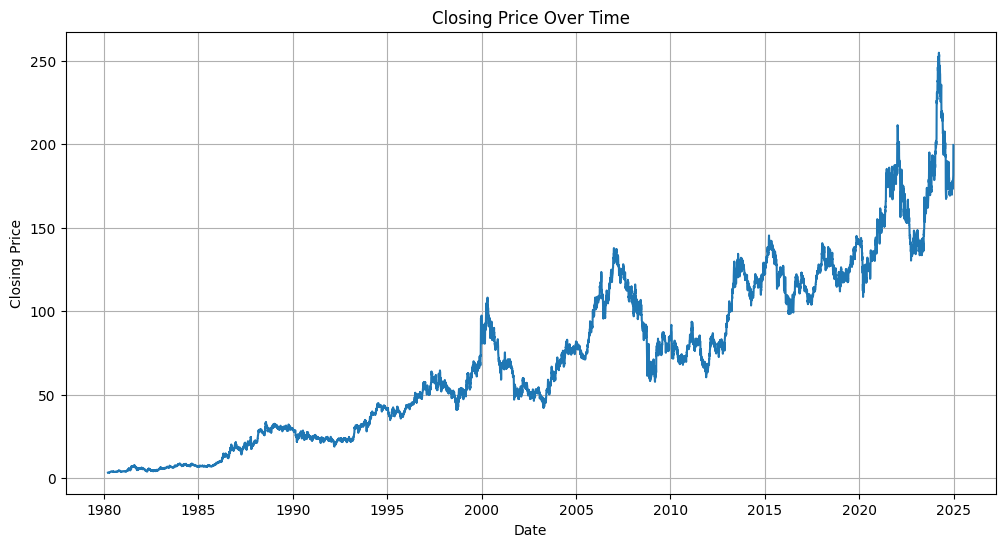

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['Close'])
plt.title('Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()

### Time series analysis


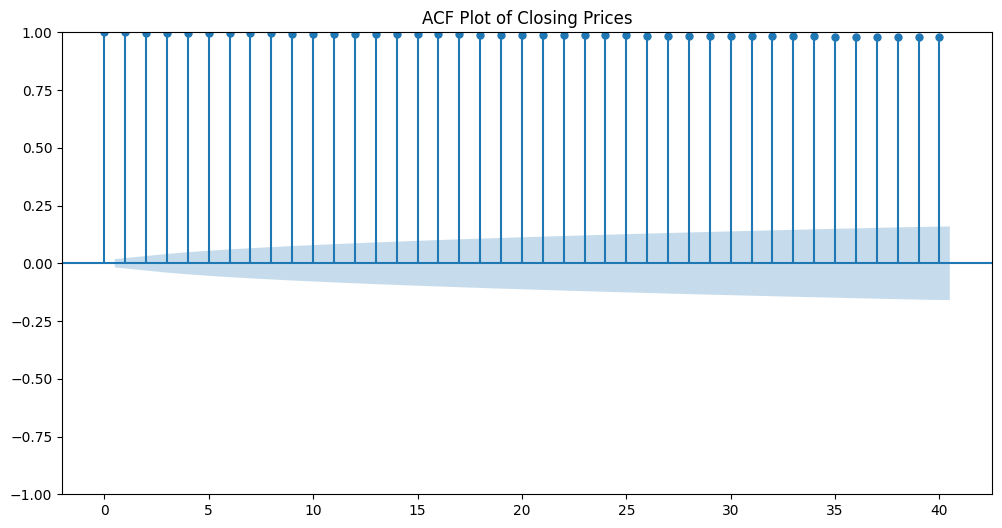

In [ ]:
# Plot ACF
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(df['Close'], lags=40, ax=ax)
plt.title('ACF Plot of Closing Prices')
plt.show()

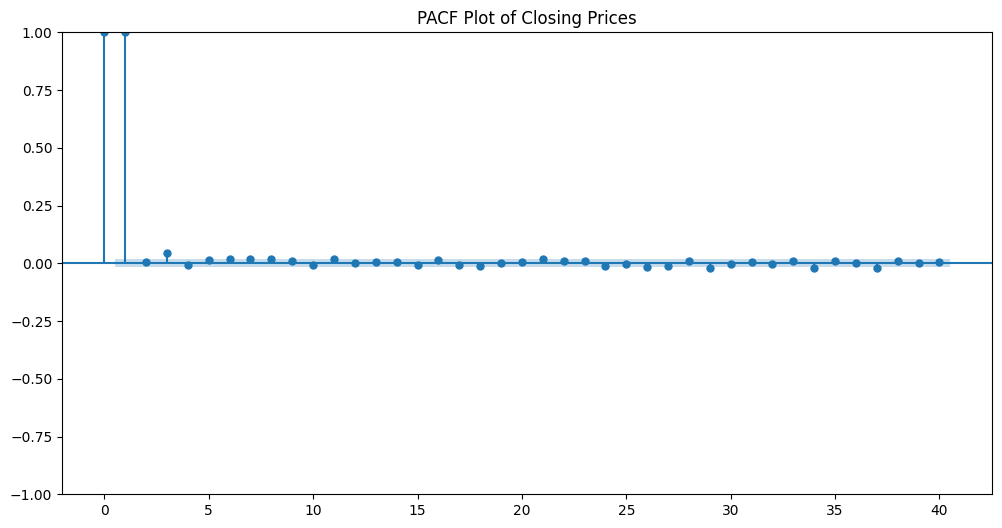

In [ ]:
# Plot PACF
fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(df['Close'], lags=40, ax=ax)
plt.title('PACF Plot of Closing Prices')
plt.show()

In [ ]:
# Conducting the ADF test
result = adfuller(df['Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -0.837853
p-value: 0.807749
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


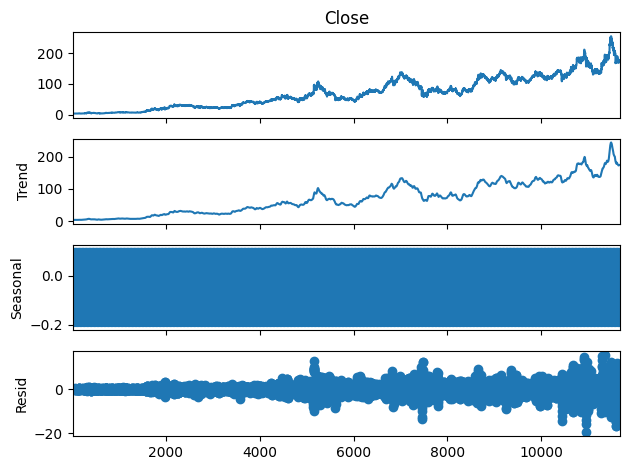

In [ ]:
# Plotting the seasonal trend decomposition

result = seasonal_decompose(df['Close'], model='additive', period=30)

# Plot the decomposition
result.plot()
plt.show()


From the autocorrelation and partial autocorrelation plots, we can infer that the model lacks clear stationarity. This was confirmed by the Augmented Dickey-Fuller (ADF) test, which failed to reject the null hypothesis

### Correlation Analysis

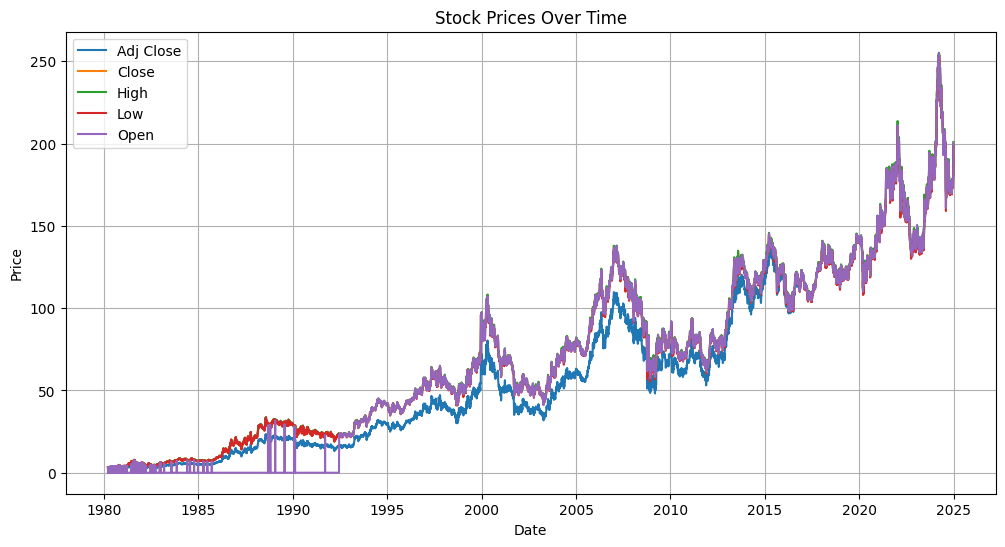

In [ ]:
cols_to_plot = ['Adj Close', 'Close', 'High', 'Low', 'Open']
plt.figure(figsize=(12, 6))

for col in cols_to_plot:
    plt.plot(df.index, df[col], label=col)

plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

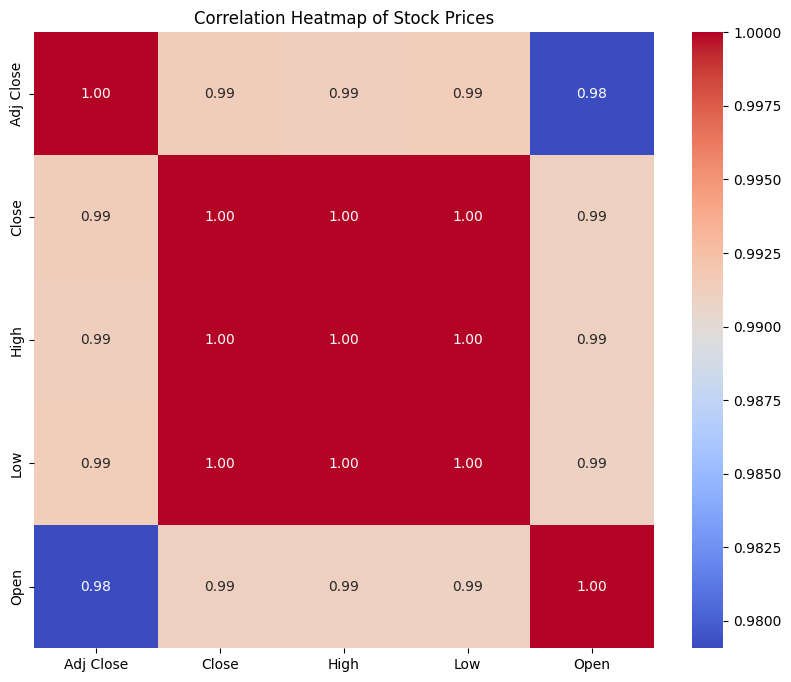

In [ ]:
# plotting correlation heatmap
cols_to_correlate = ['Adj Close', 'Close', 'High', 'Low', 'Open']
correlation_matrix = df[cols_to_correlate].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Stock Prices')
plt.show()


from above plots it was visible that our features are highly correlated with each other


---



###Technical Indicators

When it comes to stock market we can not forget about the importance of technical indicators. We also tried incoparating some technical indicators related to stock market for our analysis



*   Exponential Moving Average (EMA)
EMA is a type of moving average that gives more weight to recent prices, making it more responsive to new information compared to a simple moving average.

*   Relative Strength Index (RSI)
RSI is a momentum oscillator that measures the speed and change of price movements, ranging from 0 to 100.



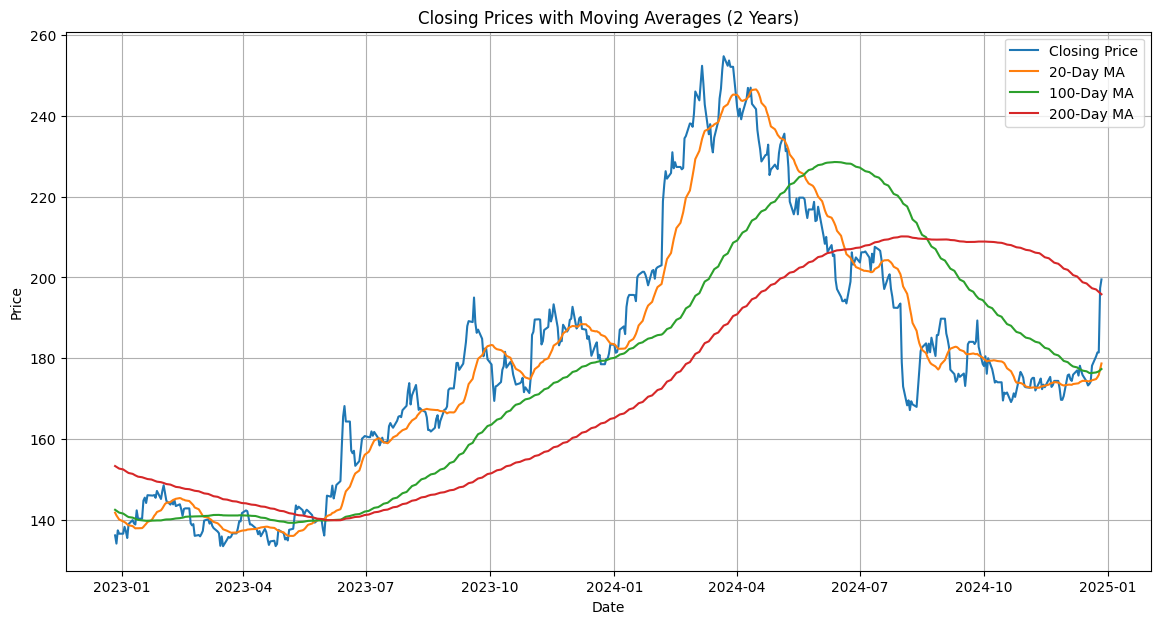

In [ ]:
# Calculate moving averages
df['MA20'] = df['Close'].rolling(window=20).mean()
df['MA100'] = df['Close'].rolling(window=100).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()

# Define the two-year period for visibility
end_date = df.index.max()
start_date = end_date - pd.DateOffset(years=2)
df_2years = df.loc[start_date:end_date]


# Plotting
plt.figure(figsize=(14, 7))
plt.plot(df_2years['Close'], label='Closing Price')
plt.plot(df_2years['MA20'], label='20-Day MA')
plt.plot(df_2years['MA100'], label='100-Day MA')
plt.plot(df_2years['MA200'], label='200-Day MA')


plt.title('Closing Prices with Moving Averages (2 Years)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


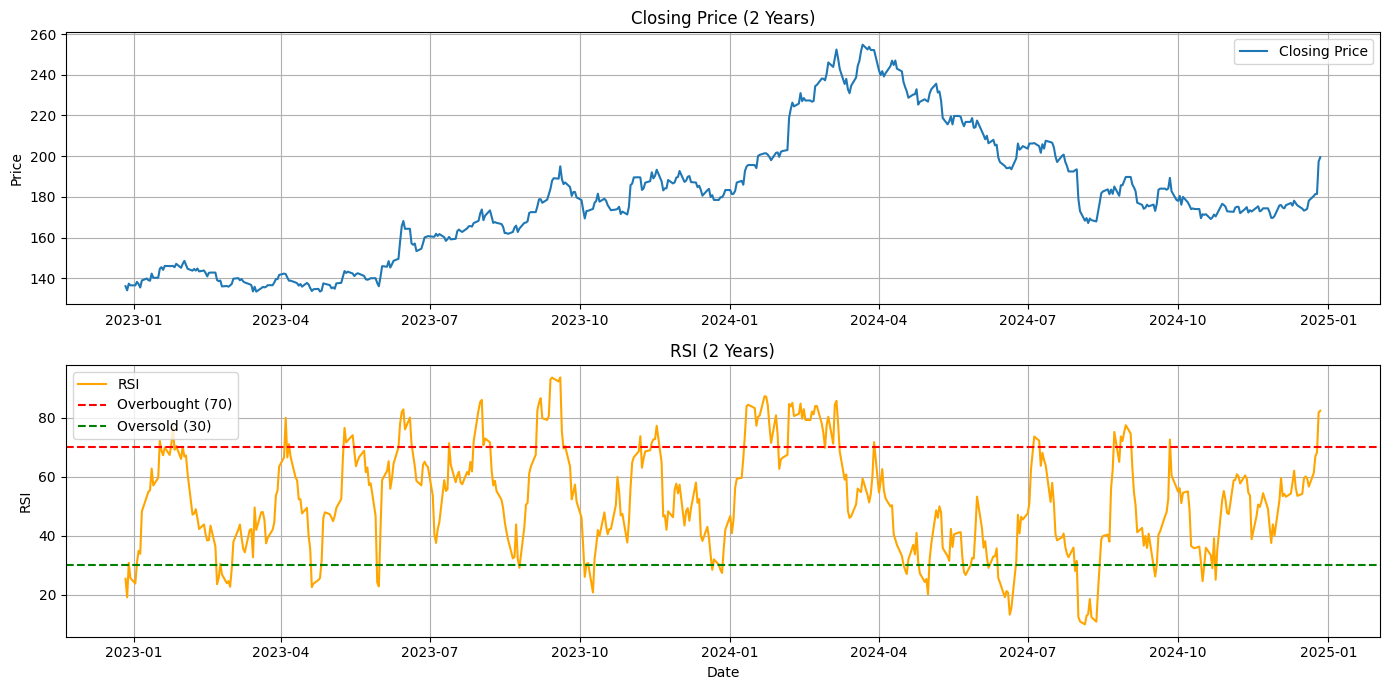

In [ ]:
# Calculate RSI
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# Define the two-year period for visibility
end_date = df.index.max()
start_date = end_date - pd.DateOffset(years=2)
df_2years = df.loc[start_date:end_date]

# Plotting Closing Price with RSI
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)  # Create two subplots
plt.plot(df_2years['Close'], label='Closing Price')
plt.title('Closing Price (2 Years)')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)  # Second subplot for RSI
plt.plot(df_2years['RSI'], label='RSI', color='orange')
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
plt.title('RSI (2 Years)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.grid(True)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


Some key insights gained were,


*   Feature Importance: The RSI and Moving Averages serve as key predictive indicators, influencing trend reversals and momentum shifts.
*   Trend Modeling: The price pattern suggests a time-series non-stationary behavior





### Understanding how to predict and what to predict

We have few options at hand


*   Predict the Difference Between Tomorrow’s and Today’s Closing Values for get an idea about directional change.
*   Predict the next day's closing price






But it turns out using the current models we have it's not easy to predict  directional change.

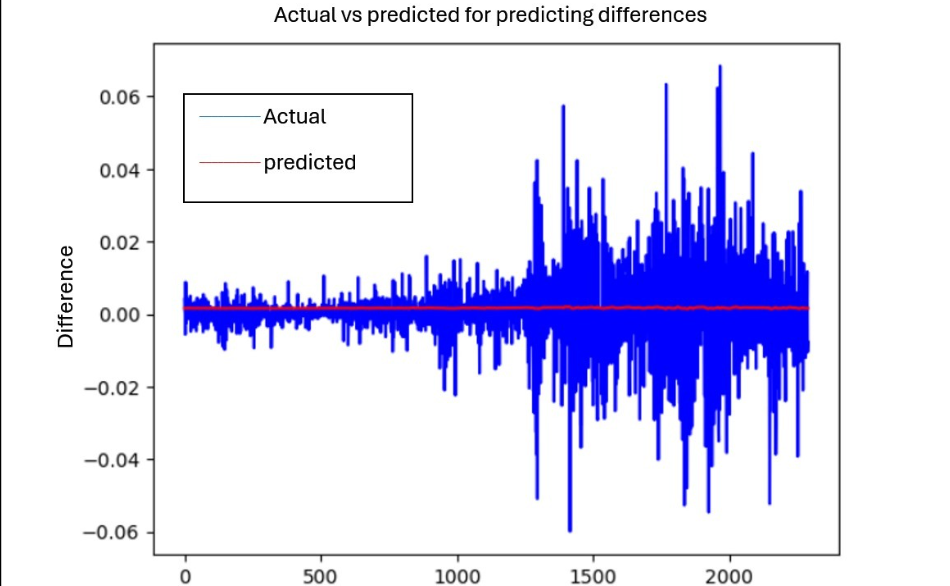



---



Key Insights from Our Analysis:

* Daily Trend Prediction is Challenging because
Market volatility and external factors make next-day movement forecasting difficult.

*  Patterns Provide Predictability
Recognizable patterns in historical data, like head-and-shoulders or support/resistance, improve model prediction accuracy.




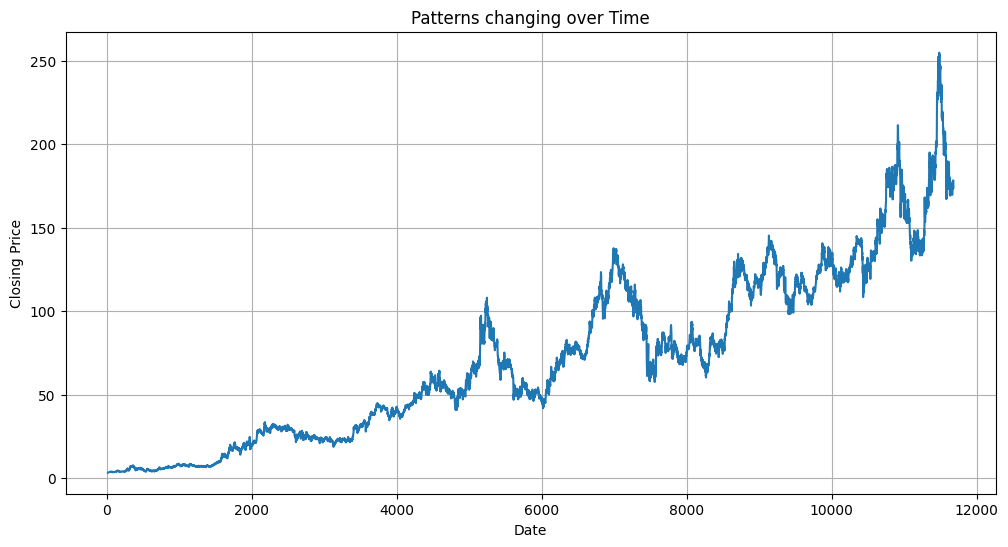

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['Close'])
plt.title('Patterns changing over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()

**Patterns change over time **

Even though we have 20-30 years of historical data, older patterns may not apply to the current market conditions.

## Feature Engineering


In the EDA state we realized that there are some new features we can eengnieer that cn give valueable insights

We can use some of the following engineered features to get a better prediction














1.   Lag Features (Close_Lag_1, Close_Lag_5)

Used to predict future price movement based on recent historical values.
Helps capture autoregressive behavior in stock prices.
2.   Moving Averages (MA_5, MA_10, MA_20)

Short-term averages (e.g., MA_5) help in detecting quick trends.
Long-term averages (e.g., MA_20) help smooth noise and indicate overall market direction.

3.   Volatility (Volatility_5, Volatility_10)

High volatility means higher uncertainty and potential sharp price swings.
Helps in risk assessment and predicting large price movements.

4.  Momentum (Momentum_5)

A positive value suggests an upward trend, while a negative value indicates a downward trend.
Helps traders identify breakout points where a stock might start rising or falling.





In [ ]:
# Lag Features (Previous closing prices)
df['Close_Lag_1'] = df['Close'].shift(1)
df['Close_Lag_5'] = df['Close'].shift(5)

# Moving Averages (5, 10, 20 days)
df['MA_5'] = df['Close'].rolling(window=5).mean()
df['MA_10'] = df['Close'].rolling(window=10).mean()
df['MA_20'] = df['Close'].rolling(window=20).mean()

# Volatility (Standard deviation of closing price)
df['Volatility_5'] = df['Close'].rolling(window=5).std()
df['Volatility_10'] = df['Close'].rolling(window=10).std()

# Momentum Indicator (Price difference over 5 days)
df['Momentum_5'] = df['Close'] - df['Close'].shift(5)

## Model training and Evaluation

For training we use several approaches



*   Training forecasting models by incoparating Engineered features and techinical indicators
*   Using a CNN model to capture complex time variant dependancies and using a LSTM layer for forecasting



### Using Engineered features with standard models


In [ ]:
# Target Variable (Stock price 5 days in the future)
df['Target_Close'] = df['Close'].shift(-5)

In [ ]:
# Select Features
features = ['Close_Lag_1', 'Close_Lag_5', 'MA_5', 'MA_10', 'MA_20', 'Volatility_5', 'Volatility_10', 'Momentum_5']
X = df[features]
y = df['Target_Close']

In [ ]:
# Drop NaN values
df = df.dropna()

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Train baseline models



*   Random Forest
*   Linear Regression
*   Vanilla LSTM



In [ ]:
# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
y_pred_rf = rf_model.predict(X_test_scaled)

# Compute RMSE
rmse_rf = mean_squared_error(y_test, y_pred_rf)**0.5
print("Fixed Random Forest RMSE:", rmse_rf)


Fixed Random Forest RMSE: 28.142280952708962


In [ ]:
# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predict & Evaluate
y_pred_lr = lr_model.predict(X_test_scaled)
rmse_lr = mean_squared_error(y_test, y_pred_lr,)**0.5

print("Fixed Linear Regression RMSE:", rmse_lr)

Fixed Linear Regression RMSE: 4.925320758161119


In [ ]:
# Reshape input for LSTM (samples, time steps, features)
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [ ]:
# Build LSTM Model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(1, X_train_scaled.shape[1])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

# Compile Model
lstm_model.compile(optimizer='adam', loss='mse')

# Train LSTM
lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=16, validation_data=(X_test_lstm, y_test), verbose=1)


Epoch 1/20
583/583 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 2305.1653 - val_loss: 1693.5652
Epoch 2/20
583/583 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 55.4076 - val_loss: 896.3522
Epoch 3/20
583/583 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 38.0458 - val_loss: 705.2996
Epoch 4/20
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 37.3032 - val_loss: 714.2141
Epoch 5/20
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 33.5730 - val_loss: 561.5046
Epoch 6/20
583/583 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 29.4034 - val_loss: 560.7356
Epoch 7/20
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 31.5948 - val_loss: 519.8933
Epoch 8/20
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 30.0176 - val_loss: 489.7467
Epoch 9/20
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 28.3439 - val_loss: 552.3506
Epoch 10/20
583/583 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 27.8724 - val_loss: 499.4382
Epoch 11/20
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 28.1050 - val_loss: 457.1311
Epoch 12/20
583

In [ ]:
# Predict using LSTM
y_pred_lstm = lstm_model.predict(X_test_lstm)

# RMSE for LSTM
rmse_lstm = mean_squared_error(y_test, y_pred_lstm)**0.5
print("Fixed LSTM RMSE:", rmse_lstm)

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fixed LSTM RMSE: 19.470174264254947


In [ ]:
# Print RMSE for all models
print("Random Forest RMSE:", rmse_rf)
print("Linear Regression RMSE:", rmse_lr)
print("LSTM RMSE:", rmse_lstm)

Random Forest RMSE: 28.142280952708962
Linear Regression RMSE: 4.925320758161119
LSTM RMSE: 19.470174264254947


#### Trying out statistical models like ARIMA and SARIMA

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
try:
    arima_model = ARIMA(df['Close'], order=(5, 1, 0))
    arima_model_fit = arima_model.fit()

    # Make predictions
    arima_predictions = arima_model_fit.predict(start=len(X_train), end=len(df)-1)
    arima_rmse = mean_squared_error(y_test, arima_predictions)**0.5
    print("ARIMA RMSE:", arima_rmse)

except Exception as e:
    print("ARIMA Error:", e)

ARIMA RMSE: 5.395899393907634


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

try:
    # Fit SARIMA model
    sarima_model = SARIMAX(df['Close'], order=(5, 1, 0), seasonal_order=(1, 1, 1, 12))
    sarima_model_fit = sarima_model.fit()

    # Make predictions
    sarima_predictions = sarima_model_fit.predict(start=len(X_train), end=len(df)-1)
    sarima_rmse = mean_squared_error(y_test, sarima_predictions)**0.5
    print("SARIMA RMSE:", sarima_rmse)

except Exception as e:
    print("SARIMA Error:", e)


SARIMA RMSE: 5.395885446601263


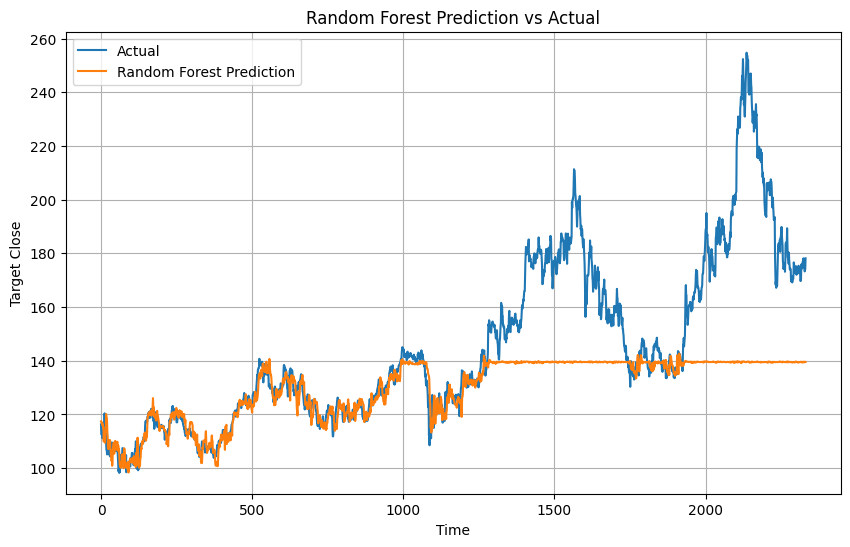

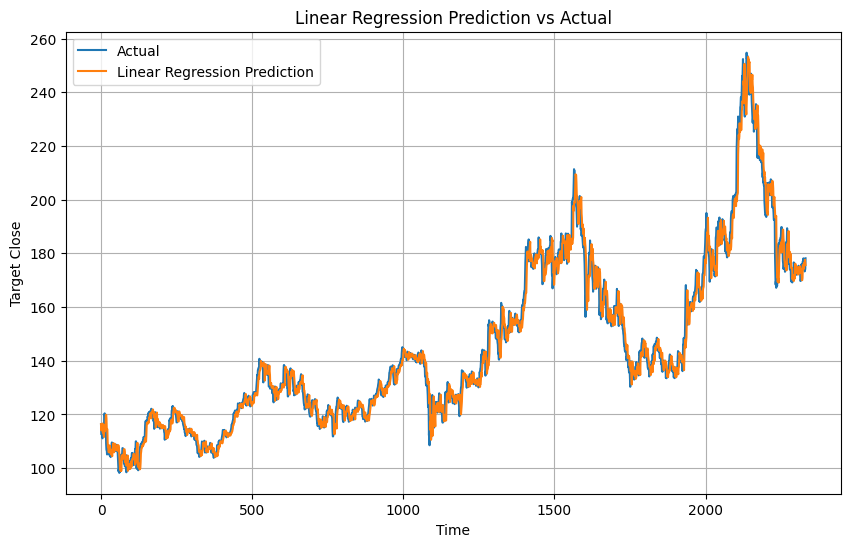

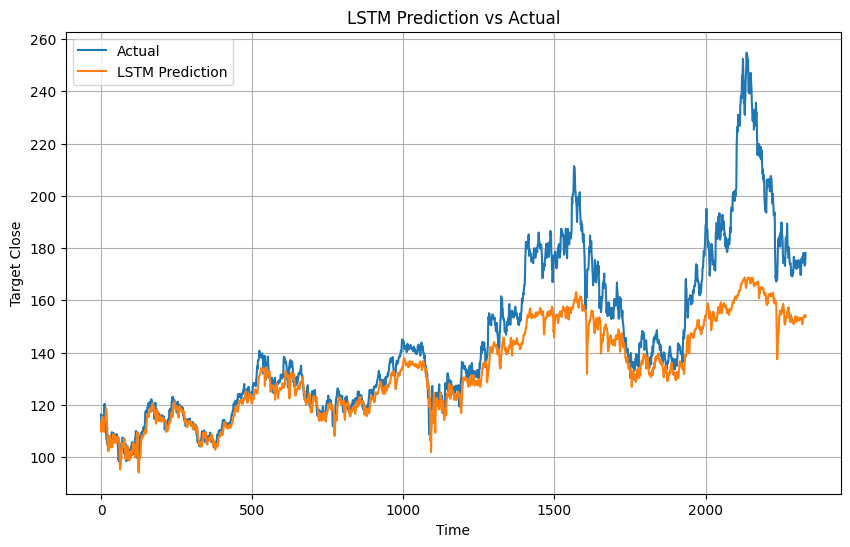

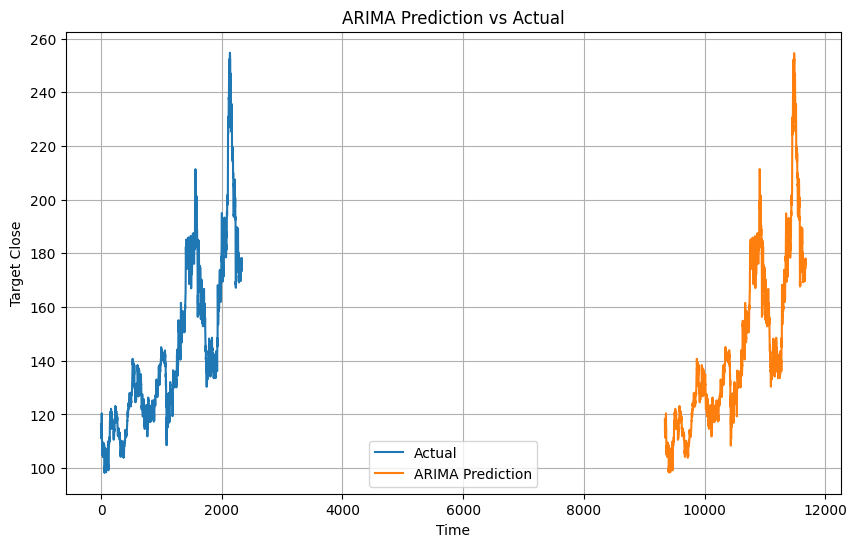

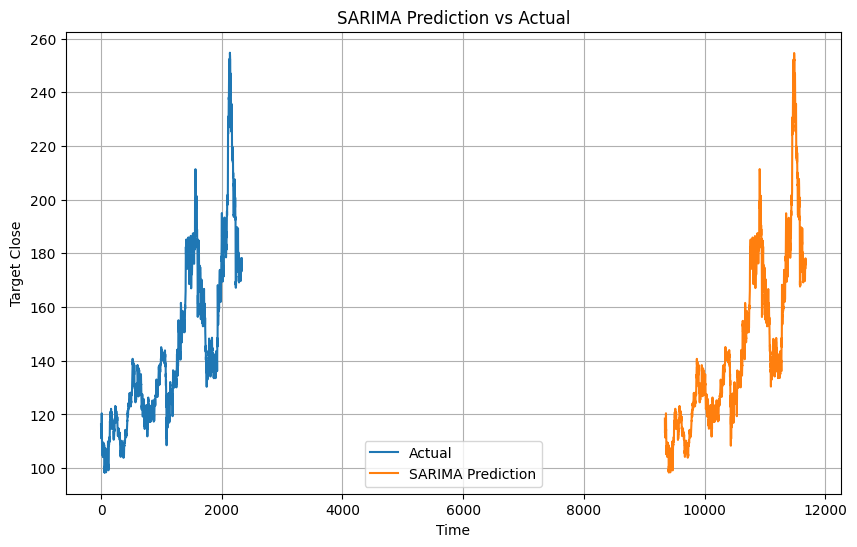

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred_rf, label='Random Forest Prediction')
plt.title('Random Forest Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Target Close')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred_lr, label='Linear Regression Prediction')
plt.title('Linear Regression Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Target Close')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred_lstm, label='LSTM Prediction')
plt.title('LSTM Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Target Close')
plt.legend()
plt.grid(True)
plt.show()

try:
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values, label='Actual')
    plt.plot(arima_predictions, label='ARIMA Prediction')
    plt.title('ARIMA Prediction vs Actual')
    plt.xlabel('Time')
    plt.ylabel('Target Close')
    plt.legend()
    plt.grid(True)
    plt.show()
except NameError:
    print("ARIMA predictions not available.")

try:
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values, label='Actual')
    plt.plot(sarima_predictions, label='SARIMA Prediction')
    plt.title('SARIMA Prediction vs Actual')
    plt.xlabel('Time')
    plt.ylabel('Target Close')
    plt.legend()
    plt.grid(True)
    plt.show()
except NameError:
    print("SARIMA predictions not available.")


### Using a CNN model with LSTM layer

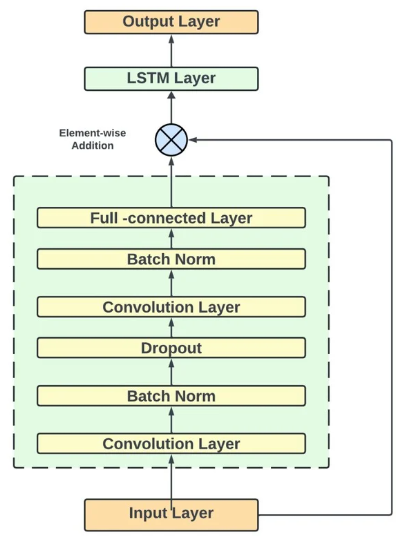

In [ ]:
original_df = pd.read_csv("original.csv")

In [ ]:
df = original_df

#### Standard Resnet + LSTM Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

In [ ]:
# Use the 'Close' price for training
data = pd.DataFrame(df["Close"])
dataset = np.reshape(data.values, (df.shape[0], 1))

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Split dataset (90% training, 10% testing)
train_ratio = 0.9
train_size = int(len(dataset) * train_ratio)
train_data = scaled_data[:train_size, :]
test_data = scaled_data[train_size - 5:, :]

In [ ]:
# Function to create time series data
def split_data(dataset, train_days, predict_days):
    x, y = [], []
    for i in range(train_days, len(dataset) - predict_days + 1):
        x.append(dataset[i - train_days : i, 0])
        y.append(dataset[i + predict_days - 1, 0])
    return np.array(x), np.array(y)

# Function to reshape data for model
def reshape_data(train_data, test_data, days):
    x_train, y_train = split_data(train_data, days, 1)
    x_test, y_test = split_data(test_data, days, 1)

    x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
    x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
    return x_train, y_train, x_test, y_test

# Use 5-day sequence length
x_train_5, y_train_5, x_test_5, y_test_5 = reshape_data(train_data, test_data, 5)


In [ ]:
# Define ResNLS model
class ResNLS(nn.Module):
    def __init__(self):
        super(ResNLS, self).__init__()
        self.weight = nn.Parameter(torch.zeros(1))
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 64, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(64),
            nn.Dropout(0.1),
            nn.Conv1d(64, 64, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(64),
            nn.Flatten(),
            nn.Linear(5 * 64, 5)
        )
        self.lstm = nn.LSTM(5, 64, batch_first=True)
        self.linear = nn.Linear(64, 1)

    def forward(self, x):
        cnn_output = self.cnn(x).view(-1, 1, 5)
        residuals = x + self.weight * cnn_output
        _, (h_n, _) = self.lstm(x)
        y_hat = self.linear(h_n[0, :, :])
        return y_hat

# Initialize model
model = ResNLS()


In [ ]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# Convert data to tensors
x_train_tensor = torch.tensor(x_train_5, dtype=torch.float)
y_train_tensor = torch.tensor(y_train_5, dtype=torch.float)
x_test_tensor = torch.tensor(x_test_5, dtype=torch.float)
y_test_tensor = torch.tensor(y_test_5, dtype=torch.float)

In [ ]:
# Training parameters
epochs = 50
batch_size = 64
batch_num = (x_train_5.shape[0] // batch_size) + 1

In [ ]:
# Training loop
for epoch in range(epochs):
    model.train()
    for j in range(batch_num):
        start = j * batch_size
        end = (j + 1) * batch_size
        train_input = x_train_tensor[start:end]
        train_target = y_train_tensor[start:end]

        optimizer.zero_grad()
        train_output = model(train_input)
        train_loss = criterion(train_output, train_target.unsqueeze(1))
        train_loss.backward()
        optimizer.step()

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_output = model(x_test_tensor)
        val_loss = criterion(val_output, y_test_tensor.unsqueeze(1))

    # Print progress
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}")


Epoch 5/50, Train Loss: 0.0000, Val Loss: 0.0003
Epoch 10/50, Train Loss: 0.0000, Val Loss: 0.0005
Epoch 15/50, Train Loss: 0.0000, Val Loss: 0.0006
Epoch 20/50, Train Loss: 0.0000, Val Loss: 0.0006
Epoch 25/50, Train Loss: 0.0000, Val Loss: 0.0006
Epoch 30/50, Train Loss: 0.0000, Val Loss: 0.0006
Epoch 35/50, Train Loss: 0.0000, Val Loss: 0.0006
Epoch 40/50, Train Loss: 0.0000, Val Loss: 0.0006
Epoch 45/50, Train Loss: 0.0000, Val Loss: 0.0006
Epoch 50/50, Train Loss: 0.0000, Val Loss: 0.0006


In [ ]:
# Predict stock prices
model.eval()
with torch.no_grad():
    predictions = model(x_test_tensor)
predictions = scaler.inverse_transform(predictions.cpu().detach().numpy())

# Calculate accuracy metrics
y_actual = np.array(data[train_size:])  # Actual values
mae = metrics.mean_absolute_error(y_actual, predictions)
mse = metrics.mean_squared_error(y_actual, predictions)
rmse = np.sqrt(mse)
print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")

MAE: 4.23, MSE: 36.02, RMSE: 6.00


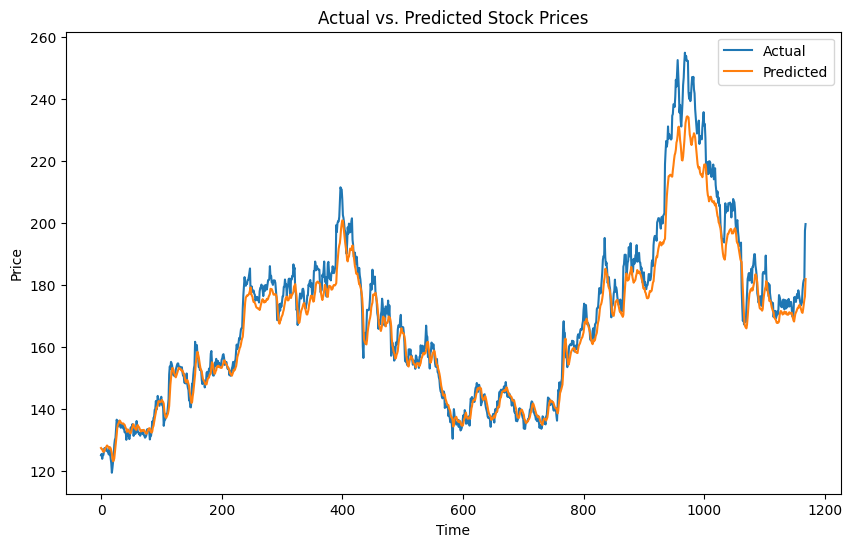

In [ ]:

plt.figure(figsize=(10, 6))
plt.plot(y_actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()


In [ ]:
# Forecast next 5 days
future_inputs = x_test_tensor[-1].cpu().numpy().reshape(1, 1, 5)
future_predictions = []
for _ in range(5):
    future_pred = model(torch.tensor(future_inputs, dtype=torch.float))
    future_pred_value = future_pred.cpu().detach().numpy().flatten()[0]
    future_predictions.append(future_pred_value)

    # Update input window
    future_inputs = np.roll(future_inputs, shift=-1)
    future_inputs[0, 0, -1] = future_pred_value

# Convert predictions back to original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Print forecasted values
print("Next 5-day forecast:")
for i, pred in enumerate(future_predictions.flatten(), start=1):
    print(f"Day {i}: {pred:.2f}")

Next 5-day forecast:
Day 1: 181.80
Day 2: 180.75
Day 3: 179.28
Day 4: 178.58
Day 5: 177.01


#### Resnet + LSTM + XGBoost Stacking

In [ ]:
# Feature Engineering
df['Close_Lag_1'] = df['Close'].shift(1)
df['Close_Lag_5'] = df['Close'].shift(5)
df['MA_5'] = df['Close'].rolling(window=5).mean()
df['MA_10'] = df['Close'].rolling(window=10).mean()
df['MA_20'] = df['Close'].rolling(window=20).mean()
df['Volatility_5'] = df['Close'].rolling(window=5).std()
df['Volatility_10'] = df['Close'].rolling(window=10).std()
df['Momentum_5'] = df['Close'] - df['Close'].shift(5)


In [ ]:
import xgboost as xgb
# Train XGBoost Model
features = ['Close_Lag_1', 'Close_Lag_5', 'MA_5', 'MA_10', 'MA_20', 'Volatility_5', 'Volatility_10', 'Momentum_5']
target = 'Close'

X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.05)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

In [ ]:
model.eval()
with torch.no_grad():
    predictions_resnls = model(x_test_tensor)
predictions_resnls = scaler.inverse_transform(predictions_resnls.numpy())

In [ ]:
# Hybrid Model - Weighted Average
alpha = 0.6  # Weight for ResNLS
beta = 0.4  # Weight for XGBoost
final_predictions = (alpha * predictions_resnls.flatten()) + (beta * y_pred_xgb)

In [ ]:
# Evaluate Hybrid Model
mse_hybrid = mean_squared_error(y_test, final_predictions)
rmse_hybrid = mse_hybrid ** 0.5
print(f'Hybrid Model RMSE: {rmse_hybrid:.4f}')

Hybrid Model RMSE: 18.4404


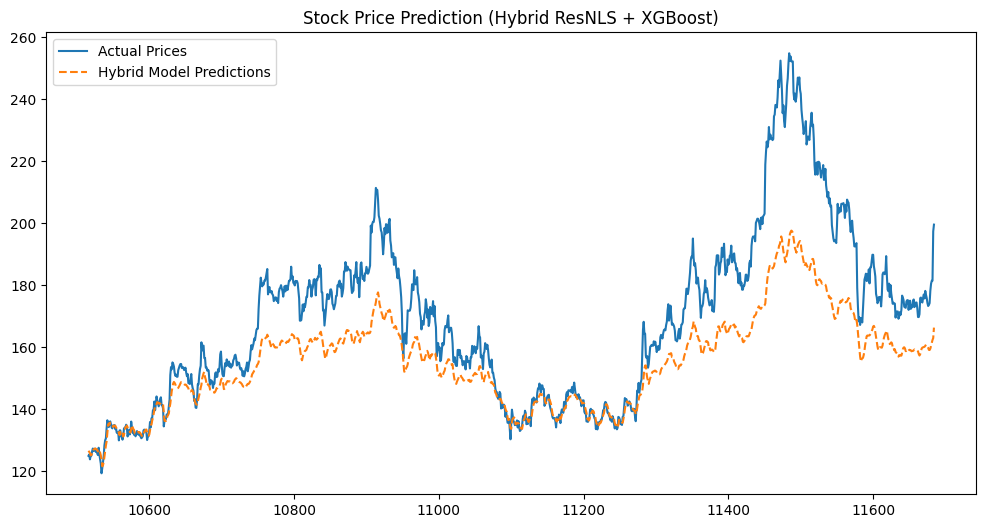

In [ ]:
# Plot Predictions
plt.figure(figsize=(12,6))
plt.plot(df.index[train_size:], df['Close'].iloc[train_size:], label="Actual Prices")
plt.plot(df.index[train_size:], final_predictions, label="Hybrid Model Predictions", linestyle='dashed')
plt.legend()
plt.title("Stock Price Prediction (Hybrid ResNLS + XGBoost)")
plt.show()